[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)

## [Paweł Magnuszewski MSc project](https://doi.org/10.48550/arXiv.2505.24435)

## arithmetic Asian call valuation

we aim to price the arithmetic Asian call option using the MPDATA solver, by solving the following PDE:
$$  \frac{\partial f}{\partial t} + rS \frac{\partial f}{\partial S} + \frac{\sigma^2}{2} S^2 \frac{\partial^2 f}{\partial S^2} + \frac{S}{T}\frac{\partial f}{\partial A} - rf = 0$$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
import numpy as np
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot, colors, colormaps, patches
from open_atmos_jupyter_utils import show_plot
from PyMPDATA_examples.Magnuszewski_et_al_2025.common import OPTIONS
from PyMPDATA_examples.Magnuszewski_et_al_2025.asian_option import AsianArithmetic, Settings
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic

In [3]:
RESOLUTION = {
    'nt': 200 if 'CI' not in os.environ else 50,
    'nx': 21 if 'CI' not in os.environ else 10,
    'ny': 31 if 'CI' not in os.environ else 10,
}

SETTINGS = Settings(
    T=1,
    K=100,
    r=.01,
    sgma=.4,
    S_max=200,
    S_min=50,
)
variant = "call"

xlim = (55, 125)
ylim = (-1, 25)
vmin = -20
vmax = 280
n_colors = 15

In [4]:
output = {k:[] for k in OPTIONS}
simulation = None
for key, opts in OPTIONS.items():
    simulation = AsianArithmetic(SETTINGS, **RESOLUTION, options=opts, variant=variant)
    for n_steps in (0, RESOLUTION['nt'] // 2, RESOLUTION['nt'] - RESOLUTION['nt'] // 2):
        simulation.step(n_steps)
        output[key].append(simulation.solver.advectee.get().copy())

### Figure 1 - advectee field dynamics

In [5]:
ax2_S2x_functions = (
    make_interp_spline(simulation.S, np.arange(len(simulation.S))),
    make_interp_spline(np.arange(len(simulation.S)), simulation.S),
)

ax2_x2S_functions = (
    ax2_S2x_functions[1],
    ax2_S2x_functions[0],
)

ax2_y2A_functions = (
    make_interp_spline(np.arange(len(simulation.A)), simulation.A),
    make_interp_spline(simulation.A, np.arange(len(simulation.A))),
)

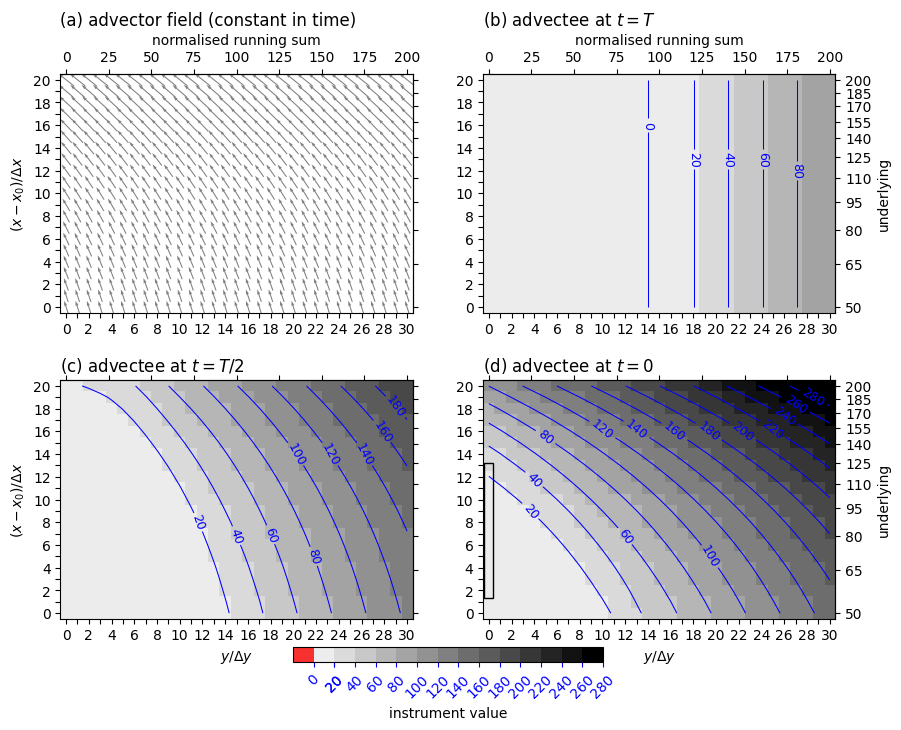

In [6]:
_, fig1_axs = pyplot.subplots(2, 2, figsize=(10, 9))

X = simulation.solver.advector.get_component(0)
X = (X[1:,:] + X[:-1,:])/2
Y = simulation.solver.advector.get_component(1)
Y = (Y[:,1:] + Y[:,:-1])/2

grid = (X.shape[1], Y.shape[0])
scale_x, scale_y = np.amax(np.abs(X)), np.amax(np.abs(Y))
imshow_common = {
    'origin': 'lower',
    'extent': (-.5, grid[0]-.5, -.5, grid[1]-.5),
}
cell_centers = np.mgrid[
    0 : grid[0] - 1/2 : 1,
    0 : grid[1] - 1/2 : 1,
]

im = fig1_axs[0][0].imshow(np.full(grid, np.nan), **imshow_common)
fig1_axs[0][0].quiver(*cell_centers, Y.T.flatten()/0.8/scale_y, X.T.flatten()/scale_x, 
    pivot='mid', 
    color='gray', 
    width=.003,
    scale=8, 
    scale_units='inches'
)
fig1_axs[0][0].set_title("(a) advector field (constant in time)", loc='left')

assert .9 * vmax < np.amax(output["MPDATA (4 it.)"][-1]) < 1.1 * vmax

newcolors = colormaps['binary'].resampled(n_colors)(np.linspace(0, 1, n_colors))
newcolors[:1, :] = np.array([248/256, 48/256, 48/256, 1])
levels=np.linspace(vmin, vmax, n_colors+1)

for i, title in enumerate(("(b) advectee at $t=T$", "(c) advectee at $t=T/2$", "(d) advectee at $t=0$")):
    im = fig1_axs[(i+1)//2][(i+1)%2].imshow(
        output["MPDATA (4 it.)"][i],
        cmap=colors.ListedColormap(newcolors),
        interpolation='nearest',
        norm=colors.Normalize(vmin=-1/(n_colors-1) * vmax, vmax=vmax),
        **imshow_common,
    )
    fig1_axs[(i+1)//2][(i+1)%2].clabel(
        fig1_axs[(i+1)//2][(i+1)%2].contour(
            *np.meshgrid(
                np.linspace(0, grid[0]-1, grid[0]),
                np.linspace(0, grid[1]-1, grid[1])
            ),
            output["MPDATA (4 it.)"][i], levels, colors='blue', linewidths=.75,
        ),
        inline=.5,
        fontsize=9
    )
    fig1_axs[(i+1)//2][(i+1)%2].set_title(title, loc='left')
pyplot.colorbar(
    im, ax=fig1_axs, shrink=.4, pad=.04, label='instrument value', orientation="horizontal", ticks=abs(levels)
).ax.tick_params(rotation=45, color='blue', labelcolor='blue')


for i in range(4):
    fig1_axs[i//2][i%2].set_xticks(range(grid[0]), ["" if j%2!=0 else f"{j}" for j in range(grid[0])])
    fig1_axs[i//2][i%2].set_yticks(range(grid[1]), ["" if j%2!=0 else f"{j}" for j in range(grid[1])])
    fig1_axs[i//2][i%2].set(
        xlabel='$y/Δy$' if i >= 2 else '',
        ylabel='$(x-x_0)/Δx$' if i % 2 == 0 else '',
        xlim=(-.5, grid[0]-.5),
        ylim=(-.5, grid[1]-.5),
    )
    
    
fig1_axs[1][1].add_patch(patches.Rectangle(
    (-.4, ax2_S2x_functions[0](xlim[0])),
    .8,
    ax2_S2x_functions[0](xlim[1]) - ax2_S2x_functions[0](xlim[0]),
    linewidth=1,
    edgecolor='black',
    facecolor='none'
))
twin_y_ticks = np.linspace(simulation.settings.S_min, simulation.settings.S_max, 11, dtype=int)
for i, twin_y in enumerate([fig1_axs[i//2][i%2].secondary_yaxis('right', functions=ax2_x2S_functions) for i in range(4)]):
    if i%2 == 1:
        twin_y.set_ylabel("underlying")
    twin_y.set_yticks(twin_y_ticks, [""] * len(twin_y_ticks) if i%2 != 1 else twin_y_ticks)

twin_x_ticks = np.linspace(0, simulation.settings.S_max, 9, dtype=int)
for i, twin_x in enumerate([fig1_axs[i//2][i%2].secondary_xaxis('top', functions=ax2_y2A_functions) for i in range(4)]):
    if i//2 == 0:
        twin_x.set_xlabel("normalised running sum")
    twin_x.set_xticks(twin_x_ticks, [""] * len(twin_x_ticks) if i//2 != 0 else twin_x_ticks)
# show_plot('advectee_over_time.pdf', inline_format='png')

### Figure 2

In [7]:
arithmetic_by_mc = np.zeros_like(simulation.S)
for idx, spot in enumerate(simulation.S):
    model = BSModel(
        S0=spot,
        r=SETTINGS.r,
        sigma=SETTINGS.sgma,
        T=SETTINGS.T,
        M=1000 if 'CI' not in os.environ else 100,
        seed=None if 'CI' not in os.environ else 44,
    )
    arithmetic_option = FixedStrikeArithmeticAsianOption(
        T=SETTINGS.T,
        K=SETTINGS.K,
        variant=variant,
        model=model,
        N=100000 if 'CI' not in os.environ else 1000
    )
    arithmetic_by_mc[idx]  = arithmetic_option.price_by_mc()

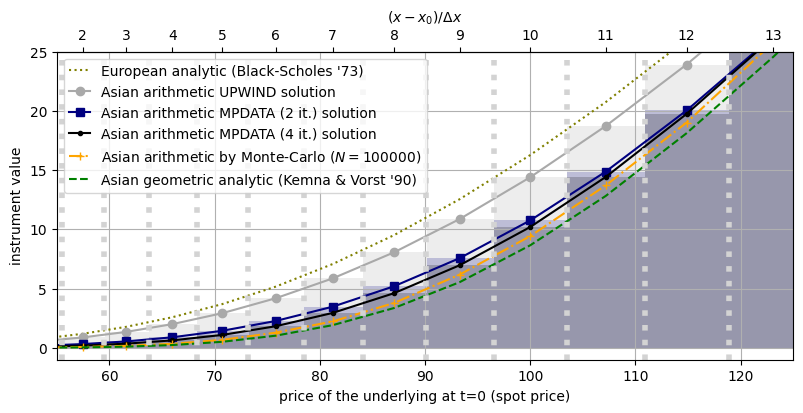

In [8]:
_, fig2_ax = pyplot.subplots(1, 1, figsize=(9.5, 4))

s_space_edges = np.exp(np.linspace(
    np.log(simulation.S[0]) - simulation.dx/2,
    np.log(simulation.S[-1]) + simulation.dx/2,
    RESOLUTION['nx'] + 1
))

euro_price = {
    "call": Black_Scholes_1973.c_euro,
    "put": Black_Scholes_1973.p_euro,
}[variant](
    S=simulation.S, K=SETTINGS.K, T=SETTINGS.T, r=SETTINGS.r, b=SETTINGS.r, sgma=SETTINGS.sgma
)

geometric_price = {
    "call": asian_analytic.geometric_asian_average_price_c,
    "put": asian_analytic.geometric_asian_average_price_p,
}[variant](
    S=simulation.S, K=SETTINGS.K, T=SETTINGS.T, r=SETTINGS.r, dividend_yield=0, sgma=SETTINGS.sgma
)

fig2_ax.set_xlim(*xlim)
fig2_ax.set_ylim(*ylim)

s_indices = np.arange(len(simulation.S))

fig2_ax.plot(
    simulation.S,
    euro_price,
    label="European analytic (Black-Scholes '73)",
    linestyle=":",
    c="olive"
)
plotcolors = {"UPWIND": "darkgray", "MPDATA (2 it.)": "navy", "MPDATA (4 it.)": "black"}
plotmarkers = {"UPWIND": "o", "MPDATA (2 it.)": "s", "MPDATA (4 it.)": "."}
for key, val in {k:v[-1] for k,v in output.items()}.items():
    fig2_ax.bar(
        s_space_edges[:-1][s_indices],
        val[:, 0][s_indices],
        width=s_space_edges[1:][s_indices] - s_space_edges[:-1][s_indices],
        alpha=0.2,
        align="edge",
        color=plotcolors[key]
    )
    fig2_ax.plot(
        simulation.S,
        val[:, 0][s_indices],
        label=f"Asian arithmetic {key} solution",
        marker=plotmarkers[key],
        c=plotcolors[key]
    )
fig2_ax.plot(
    simulation.S,
    arithmetic_by_mc[s_indices],
    label=f"Asian arithmetic by Monte-Carlo ($N={arithmetic_option.N}$)",
    marker="+",
    c="orange",
    linestyle="-.",
)

fig2_ax.plot(
    simulation.S,
    geometric_price,
    label="Asian geometric analytic (Kemna & Vorst '90)",
    linestyle="--",
    c="green"
)
ax2 = fig2_ax.secondary_xaxis('top', functions=ax2_S2x_functions)
ax2.set_xlabel("$(x-x_0)/Δx$")
ax2.set_xticks(s_indices)
for tick in ax2.get_xticks():
    fig2_ax.axvline(ax2_S2x_functions[1](tick + .5), color='lightgray', linestyle=':', linewidth=4)
fig2_ax.set(
    xlabel="price of the underlying at t=0 (spot price)",
    ylabel="instrument value",
)
fig2_ax.legend(loc="upper left", handlelength=1.5)
fig2_ax.grid()

# show_plot('numeric_vs_analytic.pdf')